In [1]:
import scipy.io
import numpy as np
from matplotlib import pyplot as plt
from skimage.morphology import square, disk, dilation  #, cube, erosion, opening, binary_erosion, closing, remove_small_holes, dilation, convex_hull_object


#load segy cube using segyio - or load test seismic 'seismic.npy'
seismic_data=np.load('seismic_volume.npy')

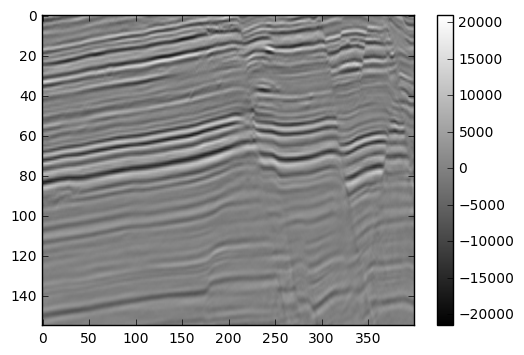

In [2]:
plt.imshow(seismic_data[:,50,:], aspect='auto', cmap='gray')
plt.colorbar()
plt.show()

In [3]:
'''Correlate non-local seismic traces with a sliding window'''

from HorizonTracker_functions import CreateGrid, DynamicTimeWarping, ExtractHorizon

grid_step=20 
window_width=100 #max distance from reference trace within window

grid=CreateGrid(seismic_data, grid_step)
path_info=DynamicTimeWarping(seismic_data, grid, window_width)

reference trace: 80 380 ( 99 out of: 100 )  time in minutes:  1.9489640514055888 Sub-block size: 30


In [4]:
events='troughs' # 'troughs', 'peaks', both'
event_spacing_parameter=5
temporary_horizons=  ExtractHorizon(seismic_data, grid, path_info, events, event_spacing_parameter)

status: horizon number 14 of 15
time in minutes:  0.10243717432022095


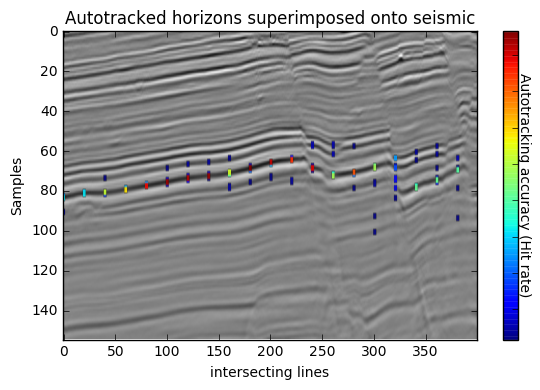

In [5]:
from HorizonTracker_functions import ShowHorizon  #view a specific horizon in IL or XL view (superimposed ontp seismic)

horizon_number=8

ShowHorizon (seismic_data, temporary_horizons, horizon_number, view='inline', line_number=60, selem=square(3))

In [6]:
from HorizonTracker_functions import HorizonAccuracyFilter

# Decide filter criterion (hardcoded or percent)
hitrate_per_trace_percent= 40 # (recommended 30-50 %)
print_output=False

filtered_horizons_binary, filtered_horizons = HorizonAccuracyFilter(seismic_data, temporary_horizons, grid, path_info, print_output, hitrate_per_trace_percent, hardcoded_minimum_hitrate=1)

filter criterion: 0.4 %. and hardcoded hitrate in general: 1


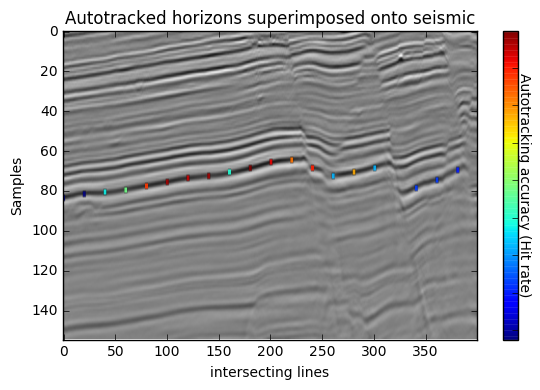

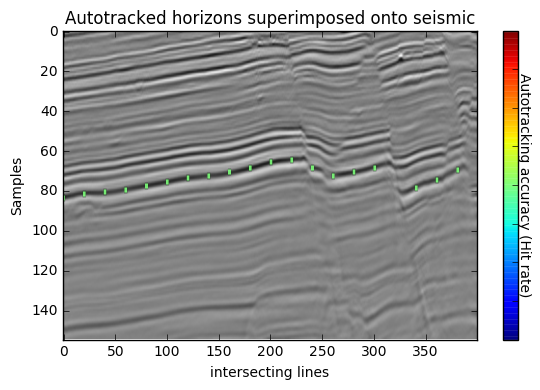

In [7]:
horizon_number=8

ShowHorizon (seismic_data, filtered_horizons, horizon_number, view='inline', line_number=60, selem=square(3))
ShowHorizon (seismic_data, filtered_horizons_binary, horizon_number, view='inline', line_number=60, selem=square(3))

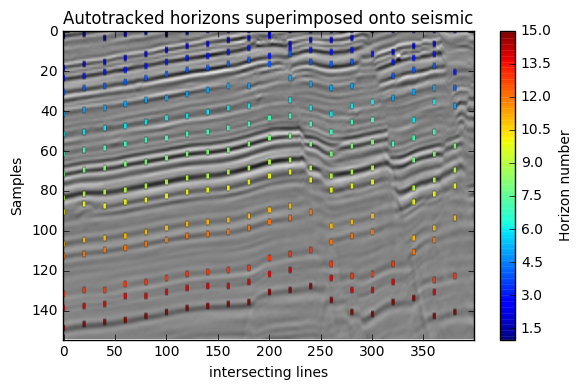

In [8]:
horizon_number='all'
ShowHorizon (seismic_data, filtered_horizons_binary, horizon_number, view='inline', line_number=60, selem=square(3))

In [9]:
from HorizonTracker_functions import regrid_horizons_DTW

dense_grid_step=5
window_size=2
dense_grid=CreateGrid(seismic_data, dense_grid_step)

regridded_horizons, dense_path_info=regrid_horizons_DTW(seismic_data, grid, grid_step, filtered_horizons_binary, dense_grid, window_size)

( 99 out of: 100 )  time in minutes:  8.726054453849793 Sub-block size: 144


In [10]:
hitrate_per_trace_percent=30
filtered_regridded_horizons_binary, filtered_regridded_horizons = HorizonAccuracyFilter(seismic_data, regridded_horizons, dense_grid, dense_path_info, print_output, hitrate_per_trace_percent, hardcoded_minimum_hitrate=1)

filter criterion: 0.3 %. and hardcoded hitrate in general: 1


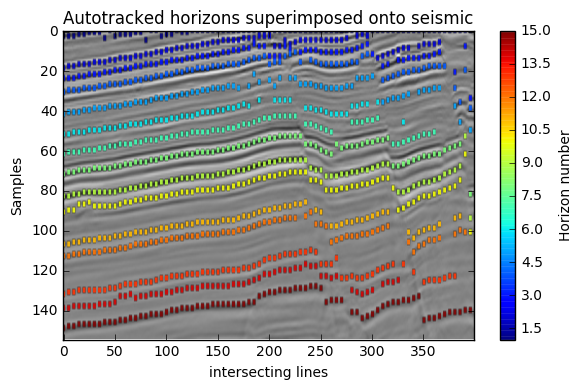

In [11]:
horizon_number='all'
ShowHorizon (seismic_data, filtered_regridded_horizons_binary, horizon_number, view='inline', line_number=60, selem=square(3))

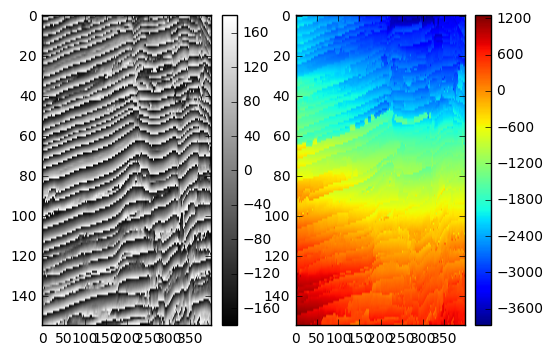

In [12]:
phase=np.load('instPhase_volume.npy')
plt.subplot(121),plt.imshow(phase[:,50,:], aspect='auto', cmap='gray')
plt.colorbar()

from skimage.restoration import unwrap_phase
unwrapped3D= unwrap_phase(phase)
plt.subplot(122),plt.imshow(unwrapped3D[:,50,:], aspect='auto')
plt.colorbar()
plt.show()

In [ ]:
from HorizonTracker_functions import interpolateHorizons3D


# criterions required for interpolation between two closest points along one gridded horizon
vertical_criterion=3
phase_criterion=50
close_neighbors=6 #can be between 4-9

interpolated_horizons=interpolateHorizons3D (unwrapped3D, filtered_regridded_horizons_binary, dense_grid_step, phase_criterion, vertical_criterion, close_neighbors)

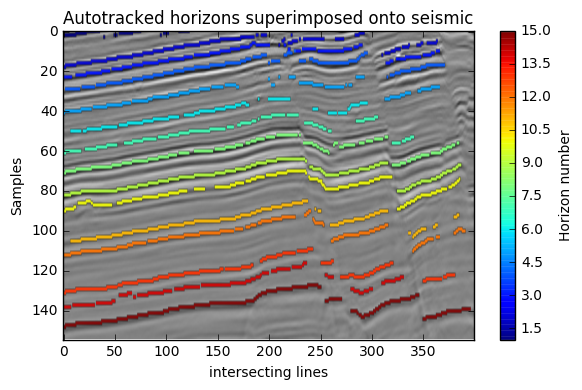

In [14]:
horizon_number='all'
ShowHorizon (seismic_data, interpolated_horizons, horizon_number, view='inline', line_number=60, selem=square(2))